In [1]:
%load_ext autoreload
%autoreload 2
from __future__ import division, print_function, absolute_import
import numpy as np
import matplotlib.pyplot as plt
fig_width = 12
%matplotlib inline

In [2]:
import bayesianchangepoint as bcp


## performing inference: application to experimental data


get your trump data:

https://github.com/bpb27/trump_tweet_data_archive

In [3]:
from io import BytesIO
from zipfile import ZipFile
import urllib.request
import json

#datafile = '/tmp/trumpets.json'
datafile = 'trumpets.json'

try:
    with open(datafile, 'r') as f:
        data = json.load(f)
except:
    years = [8] #[2, 3, 4, 5, 6, 7]
    data = []
    for year in years:
        url = urllib.request.urlopen("https://github.com/bpb27/trump_tweet_data_archive/blob/master/master_201{0}.json.zip?raw=true".format(str(year)))

        with ZipFile(BytesIO(url.read())) as my_zip_file:
            for contained_file in my_zip_file.namelist():
                with my_zip_file.open(contained_file) as f:
                    #data.extend(json.load(f))
                    data.extend(json.loads(f.read().decode('utf-8')))
    with open(datafile, 'w') as f:
        json.dump(data, f)          

In [4]:
n_tweets = len(data)

## example tweet

In [5]:
d = data[34]
d#.keys()#['followers_count']

{'contributors': None,
 'coordinates': None,
 'created_at': 'Thu Dec 28 15:24:53 +0000 2017',
 'display_text_range': [0, 288],
 'entities': {'hashtags': [], 'symbols': [], 'urls': [], 'user_mentions': []},
 'favorite_count': 65832,
 'favorited': False,
 'full_text': 'Vanity Fair, which looks like it is on its last legs, is bending over backwards in apologizing for the minor hit they took at Crooked H. Anna Wintour, who was all set to be Amb to Court of St James’s &amp; a big fundraiser for CH, is beside herself in grief &amp; begging for forgiveness!',
 'geo': None,
 'id': 946401576381505536,
 'id_str': '946401576381505536',
 'in_reply_to_screen_name': None,
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'is_quote_status': False,
 'lang': 'en',
 'place': None,
 'retweet_count': 14587,
 'retweeted': False,
 'source': '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',


## evolution of followers

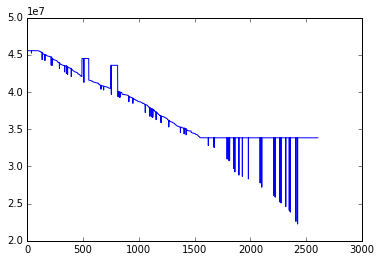

In [6]:
followers = [data[i]['user']['followers_count'] for i in range(n_tweets)]
plt.plot(followers);

In [7]:
i= 42
data_texts = []
for i in range(n_tweets):
    try:
        data_texts.append(data[i]['full_text'].lower())
    except KeyError:
        data_texts.append(data[i]['text'].lower())

data_texts[i]

'to all americans-\n#happynewyear &amp; many blessings to you all! looking forward to a wonderful &amp; prosperous 2017 as we… https://t.co/1asdmal4iy'

In [8]:
word = 'america'
contains_word = np.array([(word in data_text) for data_text in data_texts])
print(sum(contains_word), 'tweets contain the word "', word, '" on a total of ', n_tweets, 'tweets')

317 tweets contain the word " america " on a total of  2605 tweets


In [9]:
p_bar, r, beliefs = bcp.inference(contains_word, h=1/1500, p0=.5)

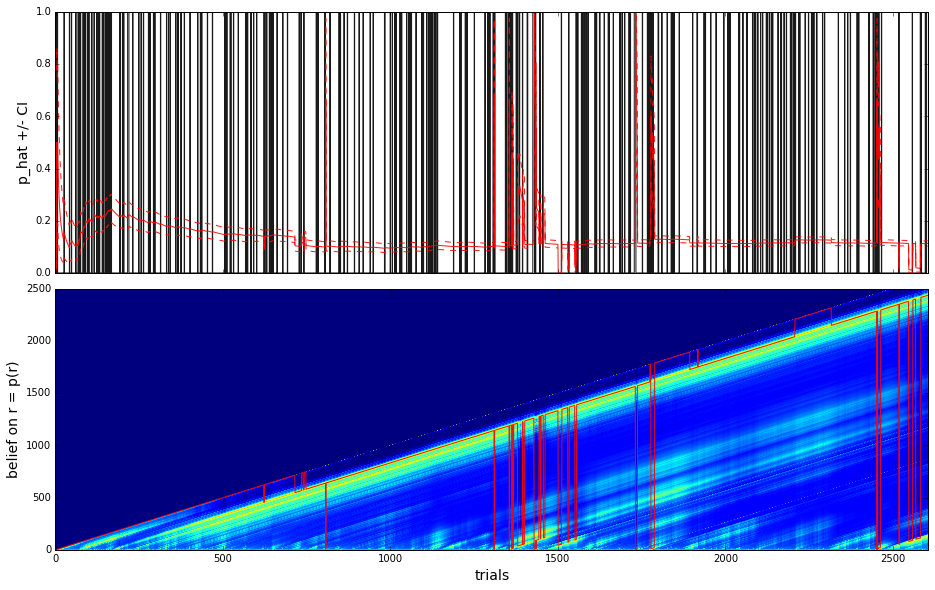

In [10]:
fig, axs = bcp.plot_inference(contains_word, None, p_bar, r, beliefs, mode='max', max_run_length=2500)

In [11]:
datetimes = [data[i]['created_at'] for i in range(n_tweets)]
print('|'+datetimes[0]+'|')

|Mon Jan 01 13:37:52 +0000 2018|


In [12]:
import locale
locale.getlocale()

('fr_FR', 'UTF-8')

In [13]:
from datetime import datetime

datetimes = [datetime.strptime(data[i]['created_at'], '%a %b %d %H:%M:%S %z %Y') for i in range(n_tweets)]
print('Timestamp=', datetimes[0].timestamp())

Timestamp= 1514813872.0


In [14]:
from datetime import datetime

datetimes = np.array([datetime.strptime(data[i]['created_at'], '%a %b %d %H:%M:%S %z %Y').timestamp() for i in range(n_tweets)])
print('Timestamp=', (datetimes[0]))

Timestamp= 1514813872.0


In [15]:
from datetime import datetime

datetimes = [datetime.strptime(data[i]['created_at'], '%a %b %d %H:%M:%S %z %Y') for i in range(n_tweets)]
print('Timestamp=', datetimes[0].timestamp())

Timestamp= 1514813872.0



Using https://matplotlib.org/examples/api/date_demo.html

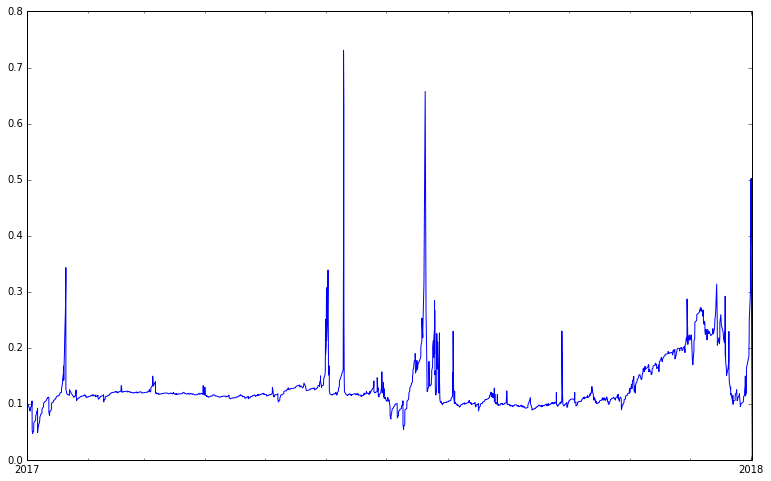

In [16]:
import datetime
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')
fig_width = 13
fig, ax = plt.subplots(figsize=(fig_width, fig_width/1.6180))

p_hat, r_hat = bcp.readout(p_bar, r, beliefs)#, mode='max')

ax.plot(datetimes, p_hat)


#datemin = datetime.date(datetimes.min(), 1, 1)
#datemax = datetime.date(datetimes.max() + 1, 1, 1)
#ax.set_xlim(datemin, datemax)
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
